# First we generate 10000 data

Preparing data

In [34]:
import os
import pandas as pd
import numpy as np
from PIL import Image

import seaborn as sns 
import matplotlib 
import matplotlib.pyplot as plt 

from keras.preprocessing.image import (ImageDataGenerator, 
                                       img_to_array, 
                                       array_to_img, 
                                       load_img)

from sklearn.model_selection import train_test_split

from sklearn.metrics import (confusion_matrix, 
                             classification_report, 
                             accuracy_score, 
                             f1_score, 
                             roc_auc_score)

import tensorflow as tf
from keras.models import Model,Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense,Flatten

from keras import optimizers
from keras import regularizers
from keras.callbacks import EarlyStopping,LearningRateScheduler


from keras import backend as K
K.clear_session()

from sklearn.utils import shuffle



In [35]:
from config import Config


config  = Config()

IMAGE_SIZE=(config.image_width, config.image_height)
IMAGE_CHANNELS= config.number_of_channels

In [36]:
train_dir = config.train_data_dir
test_dir = config.test_data_dir

In [37]:
def label(path): 
    return [file.split('_')[0] for file in os.listdir(path)]

def filename(path):
    return [file for file in os.listdir(path)]

train_names = filename(train_dir) 
test_names = filename(test_dir)
train_class = label(train_dir)


In [38]:
test_class = label(test_dir)
test_df = pd.DataFrame({'filename': test_names , 'category': test_class})


In [39]:
train_df = pd.DataFrame({ 'filename': train_names, 'category': train_class})


In [40]:
valid_df, train_df = train_test_split(train_df, test_size = (6/8))

In [41]:
batch_size = 132


In [42]:
train_map = ImageDataGenerator()
valid_map = ImageDataGenerator()
test_map =  ImageDataGenerator()

In [43]:
train_data = train_map.flow_from_dataframe(
            train_df,train_dir,
            x_col = 'filename',
            y_col = 'category',
            target_size = IMAGE_SIZE,
            batch_size = batch_size,
            class_mode = 'categorical')

valid_data = valid_map.flow_from_dataframe(
             valid_df, train_dir,
             x_col = 'filename',
             y_col = 'category',
             target_size = IMAGE_SIZE,
             batch_size = batch_size,
             class_mode = 'categorical')


test_data = test_map.flow_from_dataframe(
             test_df, train_dir,
             x_col = 'filename',
             y_col = None,
             target_size = IMAGE_SIZE,
             batch_size = batch_size,
             class_mode = None,
             shuffle = False)

Found 6000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames.


Model

In [44]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(config.image_width, config.image_height, config.number_of_channels
                                                            )))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) 


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       7

In [45]:
loss = 'categorical_crossentropy'
opt = tf.keras.optimizers.Adam(learning_rate= 0.001)
metrics = ['accuracy']

train_images = train_df.shape[0]
valid_images = valid_df.shape[0]
model.compile(loss = loss, optimizer = opt, metrics = metrics)


# fitting the model for training dataset
history = model.fit(train_data, epochs = 50,
                          validation_data = valid_data,
                          validation_steps= valid_images//batch_size,
                          steps_per_epoch= train_images//batch_size)

Epoch 1/50
45/45 [==============================] - 19s 259ms/step - loss: 491.7973 - accuracy: 0.5752 - val_loss: 0.3300 - val_accuracy: 0.8475
Epoch 2/50
45/45 [==============================] - 4s 83ms/step - loss: 0.0687 - accuracy: 0.9767 - val_loss: 0.0359 - val_accuracy: 0.9894
Epoch 3/50
45/45 [==============================] - 4s 80ms/step - loss: 0.0322 - accuracy: 0.9888 - val_loss: 0.0136 - val_accuracy: 1.0000
Epoch 4/50
45/45 [==============================] - 4s 82ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 1.1308e-04 - val_accuracy: 1.0000
Epoch 5/50
45/45 [==============================] - 4s 87ms/step - loss: 0.0046 - accuracy: 0.9991 - val_loss: 3.0780e-04 - val_accuracy: 1.0000
Epoch 6/50
45/45 [==============================] - 4s 80ms/step - loss: 5.3811e-04 - accuracy: 0.9999 - val_loss: 6.9784e-06 - val_accuracy: 1.0000
Epoch 7/50
45/45 [==============================] - 4s 88ms/step - loss: 0.0055 - accuracy: 0.9994 - val_loss: 0.0146 - val_accuracy: 

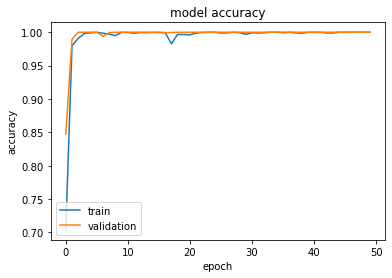

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()


# Lets train the data on model with batch normalization as well in order to compare them 


In [47]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(config.image_width, config.image_height, config.number_of_channels
                                                            )))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(2, activation='softmax')) 


model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 47, 47, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)       

In [48]:
loss = 'categorical_crossentropy'
opt = tf.keras.optimizers.Adam(learning_rate= 0.001)
metrics = ['accuracy']


model2.compile(loss = loss, optimizer = opt, metrics = metrics)


# fitting the model for training dataset
history_2 = model2.fit(train_data, epochs = 50,
                          validation_data = valid_data,
                          validation_steps= valid_images//batch_size,
                          steps_per_epoch= train_images//batch_size)

Epoch 1/50
45/45 [==============================] - 4s 81ms/step - loss: 0.1851 - accuracy: 0.9401 - val_loss: 1.8721 - val_accuracy: 0.5682
Epoch 2/50
45/45 [==============================] - 4s 88ms/step - loss: 2.2462e-04 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 0.9985
Epoch 3/50
45/45 [==============================] - 4s 84ms/step - loss: 1.8604e-04 - accuracy: 1.0000 - val_loss: 0.0397 - val_accuracy: 0.9859
Epoch 4/50
45/45 [==============================] - 4s 78ms/step - loss: 3.8376e-04 - accuracy: 1.0000 - val_loss: 0.0789 - val_accuracy: 0.9712
Epoch 5/50
45/45 [==============================] - 3s 76ms/step - loss: 1.3849e-05 - accuracy: 1.0000 - val_loss: 0.0513 - val_accuracy: 0.9813
Epoch 6/50
45/45 [==============================] - 4s 79ms/step - loss: 1.6810e-05 - accuracy: 1.0000 - val_loss: 0.0220 - val_accuracy: 0.9924
Epoch 7/50
45/45 [==============================] - 4s 80ms/step - loss: 1.1258e-05 - accuracy: 1.0000 - val_loss: 0.0037 - val_accura

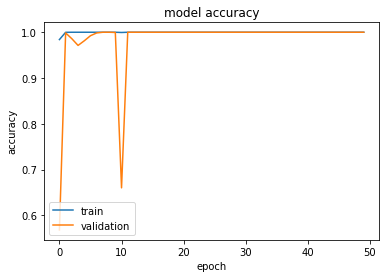

In [49]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()


# Test Data

Prediction for model with out batch normalization 

In [50]:
pred = model.predict(test_data)
test_df['pred'] = np.argmax(pred, axis = -1)
labels = dict((v,k) for k,v in train_data.class_indices.items())

test_df['pred'] = test_df['pred'].map(labels)

Prediction for model with batch normalization 

In [51]:
pred_2 = model2.predict(test_data)
test_df['pred_2'] = np.argmax(pred, axis = -1)
labels_2 = dict((v,k) for k,v in train_data.class_indices.items())

test_df['pred_2'] = test_df['pred_2'].map(labels_2)